In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from pilco.policies.rbf_policy import RBFPolicy
from pilco.agents.agents import EQGPAgent

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tqdm import trange

In [3]:
rbf_policy = RBFPolicy(2, 1, 5, dtype=tf.float32)
rbf_policy.reset()

In [4]:
loc = tf.zeros(2, dtype=tf.float32)
cov = tf.eye(2, dtype=tf.float32)

mean_u, cov_su, cov_uu = rbf_policy.match_moments(loc, cov)

cov1 = tf.concat([cov, cov_su[None, :]], axis=0)
cov2 = tf.concat([cov_su[:, None], cov_uu[None, None]], axis=0)

cov_full = tf.concat([cov1, cov2], axis=1)

mean_full = tf.concat([loc, mean_u[None]], axis=0)

print('All eigenvalues are postive:', bool(tf.reduce_all(tf.cast(tf.linalg.eig(cov_full)[0], dtype=tf.float32) > 0)))

print('mean_full:')
print(mean_full.numpy())
print('cov_full:')
print(cov_full.numpy())

All eigenvalues are postive: True
mean_full:
[0.         0.         0.04673618]
cov_full:
[[1.         0.         0.05268468]
 [0.         1.         0.01972223]
 [0.05268468 0.01972223 0.07965443]]


In [5]:
num_samples = 10**1

states = []
actions = []

for i in trange(num_samples):
    
    s = tf.random.normal(mean=0., stddev=1., shape=(2,))
    
    u = rbf_policy(s)
    
    states.append(s)
    actions.append(u)
    
s = tf.convert_to_tensor(states)
u = tf.convert_to_tensor(actions)

100%|██████████| 10/10 [00:00<00:00, 449.30it/s]


In [6]:
su_samples = tf.concat([s, u[..., None]], axis=-1)

print('MC mean_full:')
mean_full = tf.reduce_mean(su_samples, axis=0)[None, ...]
print(mean_full.numpy())

print('MC cov_full:')
cov_full = (tf.einsum('ij, ik -> jk', su_samples, su_samples) / su_samples.shape[0])
cov_full = cov_full - (tf.einsum('ij, ik -> jk', mean_full, mean_full) / mean_full.shape[0])
print(cov_full.numpy())

MC mean_full:
[[0.01521944 0.09104783 0.04795003]]
MC cov_full:
[[ 0.8714018   0.38621718  0.03390636]
 [ 0.38621718  1.0875224  -0.0288932 ]
 [ 0.03390636 -0.0288932   0.02015717]]


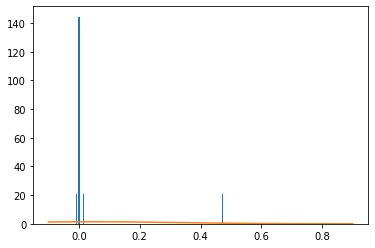

In [7]:
n = tfd.Normal(loc=mean_u, scale=tf.math.sqrt(cov_uu))

xs = tf.linspace(-0.1, .9, 100)
ys = n.prob(xs)

plt.hist(u, bins=100, density=True)
plt.plot(xs, ys)
plt.show()

In [8]:
tf.random.set_seed(24)

rbf_policy = RBFPolicy(state_dim=2,
                       action_dim=1,
                       num_rbf_features=5,
                       dtype=tf.float64)
rbf_policy.reset()

agent = EQGPAgent(state_dim=2,
                  action_dim=1,
                  policy=rbf_policy,
                  dtype=tf.float64)

states = []
actions = []
next_states = []

for i in range(50):
    
    state = tf.random.normal(mean=0., stddev=5., shape=(2,), dtype=tf.float64) 
    next_state = tf.random.normal(mean=0., stddev=5., shape=(2,), dtype=tf.float64)
    action = tf.random.normal(mean=0., stddev=5., shape=(1,), dtype=tf.float64)
    
    states.append(state)
    actions.append(action)
    next_states.append(next_state)
    
    agent.observe(state, action, next_state)

In [9]:
state_loc = tf.zeros(2, dtype=tf.float64)
state_cov = tf.eye(2, dtype=tf.float64)

# Match moments for the joint state-action distribution
mean_u, cov_su, cov_uu = rbf_policy.match_moments(state_loc, state_cov)

cov1 = tf.concat([state_cov, cov_su[None, :]], axis=0)
cov2 = tf.concat([cov_su[:, None], cov_uu[None, None]], axis=0)

cov_full = tf.concat([cov1, cov2], axis=1)

mean_full = tf.concat([state_loc, mean_u[None]], axis=0)

joint_dist = tfd.MultivariateNormalTriL(loc=mean_full,
                                        scale_tril=tf.linalg.cholesky(cov_full))

# Stuff we're tying to get to match
analytic_moments = agent.match_moments(mean_full, cov_full)
#analyitic_moments

In [10]:
num_samples = 10**3

means = []
covs = []

Qs = []

# MC approx
for i in trange(num_samples):
    
    state_action = joint_dist.sample()
    
    mean, cov = agent.gp_posterior_predictive(state_action[None, :])
    
    # S x 1 x N
    k = agent.exponentiated_quadratic(state_action[None, :], agent.dynamics_inputs)
    
    # S x S x N x N
    Q = tf.einsum('aij, bkl -> abjl', k, k)
    
    Qs.append(Q)
    
    means.append(mean)
    covs.append(cov)
    
means = tf.concat(means, axis=0)
covs = tf.stack(covs, axis=0)

100%|██████████| 1000/1000 [00:10<00:00, 97.67it/s]


In [11]:
emp_Q = tf.reduce_mean(tf.stack(Qs, axis=0), axis=0)
beta = agent.beta

emp_beta_Q_beta = tf.einsum('ai, bj, abij -> ab',
                            beta,
                            beta,
                            emp_Q)

emp_beta_Q_beta

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[0.65436911, 0.0262174 ],
       [0.0262174 , 0.33661775]])>

In [12]:
emp_mean = tf.reduce_mean(means, axis=0)
print(emp_mean)

emp_var = tf.reduce_mean(covs, axis=[0, 2, 3])

emp_cov = tf.reduce_mean(means[:, :, None] * means[:, None, :], axis=0)
print(emp_cov)

emp_cov = emp_cov - emp_mean[:, None] * emp_mean[None, :]

emp_cov = emp_cov + tf.linalg.diag(emp_var)
print(emp_cov)

tf.Tensor([ 0.5365647  -0.03342383], shape=(2,), dtype=float64)
tf.Tensor(
[[0.65436911 0.0262174 ]
 [0.0262174  0.33661775]], shape=(2, 2), dtype=float64)
tf.Tensor(
[[1.34605372 0.04415145]
 [0.04415145 1.31508688]], shape=(2, 2), dtype=float64)


In [13]:
analytic_moments

(<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.55350528, -0.03865606])>,
 <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[1.35712445, 0.02847125],
        [0.02847125, 1.31747261]])>)